## Imports and Needed functions

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Dec 6, 2023

@author: Jamiree Harrison
         https://github.com/Jamiree
         jamiree@ucsb.edu

Purpose of script: 
Simulates hybrid promoter data. 
Produces hybrid promoter model parameters that fit the simulated data. 
The assumed model is that of protein synthesis, we simply fit the parameters 
of this model at different time intervals. 

"""

# Imports
import numpy as np
from numpy import linalg as LA
import math
import matplotlib.pyplot as plt
import random
import ruptures as rpt
import statistics as stats
import string
from scipy.stats import sem
from scipy.signal import savgol_filter
from scipy.linalg import toeplitz
from mpl_toolkits import mplot3d
from random import gauss
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from ruptures.metrics import hausdorff
import os

font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 13}

plt.rc('font', **font)



## Backend Functions

In [2]:
############################################################ 

''' Uses binary segmentation to detect when a signal switches
    
    Documentation: 
    https://centre-borelli.github.io/ruptures-docs/user-guide/detection/binseg/

'''
def bkpt_binseg(signal, model, sigma): 
    
    n = len(signal)
    
    # Point Detection:
    # here we choose the Least-squares estimate for changes in autoregressive (ar) coefficients
    algo = rpt.Binseg(model=model).fit(signal)
    
    # manually select how many breakpoints to select
    if type(sigma) == str:
        sigma = int(sigma)
        my_bkps = algo.predict(n_bkps=sigma)
        
        # show results
        # rpt.show.display(signal, my_bkps, figsize=(10, 6))
        # plt.show()
        
    else:
    
        ## if we want to treat the number of change points as unknown, use
        ## one of the following (note: sigma is the standard deviation of the noise. ) : 

        ## specify a penalty using the pen parameter
        # sigma = 0.1
        # dim = 1
        # my_bkps = algo.predict(pen=np.log(n) * sigma**2)

        ## specify a threshold on the residual norm using epsilon
        ## note that sigma needs to be small for non-noisy data
        my_bkps = algo.predict(epsilon = n * sigma**2)

        # show results
        # rpt.show.display(signal, my_bkps, figsize=(10, 6))
        # plt.show()

    return my_bkps


############################################################ 

''' Detects the times that a signal "switches"

inputs:  data                            | array of size (num_time_pts, num_states)
             - each column of the data array is the evolution of that state in time
         t                               | array of size (num_time_pts, 1)
             - time vector
             
         switch_gap                      | integer
             - must define the number of indices that is allowable
                between switches.  If switch_gap is zero, then you 
                cannot have consecutive time points being switch times
        
         ls_model                           | str
            - pick from the following least-squares estimates:
                "l1", "l2", "rbf", "linear", "normal", "ar",...
        
         \\sigma   (type determined)     | float 
                                 | (if the number of switches is
                                 | to be determined by algorithm)
            - standard deviation of the noise in the data
         \\sigma   (type determined)     | str 
                                | (if the number of switches is
                                | to be input by the user)
            - standard deviation of the noise in the data
                
outputs: t_switch_index         | array of size (num_switches, 0) 
         num_switches           | integer
         num_time_intervals     | integer
         time_of_switch         | array of size (num_switches, 0) 
'''
def switch_time_detect(data, t, switch_gap, ls_model, sigma):
    
    num_time_pts, num_states = np.shape(data)
    
    true_t_switch_index = np.array([], dtype=int)
    
    # iterate over all states of system
    for j in range(num_states):
        
        # detects switch time using binary segmentation 
        t_switch_index = bkpt_binseg(data[:,j], ls_model, sigma)

        # the following code removes switch indices that are too close for each state
        result = [t_switch_index[0]]
        for i in range(1, len(t_switch_index)):
            # enforces consecutive switches are not too close
            if t_switch_index[i] > t_switch_index[i - 1] + switch_gap:
                # appends current indexed entry
                result = np.append(result, t_switch_index[i])

        # makes it so that the last time point cannot be a switch time
        if result[-1] == len(t):
            result = np.delete(result, -1)
            
        
        # indices of t where state switching occurs in the j-th state
        t_switch_index = result 
        
        # print('switches = ',t_switch_index)
        
        # only takes switches not already detected from previous states
        for entry in t_switch_index:
            if entry not in true_t_switch_index:
                true_t_switch_index = np.append(true_t_switch_index, entry)
        true_t_switch_index = np.sort(true_t_switch_index)

        # print('time indices of switches: ', true_t_switch_index)
        
    # checks if there are no switches
    if len(true_t_switch_index) == 0:

        num_switches = 0
        time_of_switch = np.zeros((num_switches,))
        num_time_intervals = num_switches + 1
        print('no switches detected in signal given chosen parameters')
        
        return true_t_switch_index, num_switches, num_time_intervals, time_of_switch
            
    else:
        result = [true_t_switch_index[0]]
        for i in range(1, len(true_t_switch_index)):
            # makes it so that consecutive switches are not too close
            if true_t_switch_index[i] > true_t_switch_index[i - 1] + switch_gap:
                # Remove the current indexed entry
                result = np.append(result, true_t_switch_index[i])
                
        # makes it so that the last time point cannot be a switch time            
        if result[-1] == len(t):
            result = np.delete(result, -1)

        true_t_switch_index = result
               
    num_switches = len(true_t_switch_index)
    
    if isinstance(sigma, str) and int(sigma) != num_switches:
        print('expected switch number not equal to detected number of switches')


    # gets times of switches
    time_of_switch = np.zeros((num_switches,))
    for i in range(num_switches):
        time_of_switch[i] = t[true_t_switch_index[i]]

    print('times_of_switches = ', time_of_switch)

    
#     plt.figure()
#     plt.plot(t, data[:,num_states//2], 'g', label='x(t)')
#     plt.plot(t[true_t_switch_index], data[true_t_switch_index, num_states//2], 'ro')
#     plt.xlabel('time')
#     plt.ylabel('cross section of u(t,x) for some x')
#     plt.title('switch times found')
#     plt.savefig(os.path.join(os.getcwd(), 'switch times.svg'), format='svg')
#     plt.show()
        
    num_time_intervals = num_switches + 1
    
#     print('num_switches =', num_switches)
#     print('num_time_intervals =', num_time_intervals)
    
    return true_t_switch_index, num_switches, num_time_intervals, time_of_switch

    
############################################################ 

''' Breaks data up into sections based on the 
    times of the switches

inputs:  data                   | array of size (num_time_pts, num_states)
             - each column of the data array is the evolution of that state in time
             
         t                      | array of size (num_time_pts, 1)
             - time vector
        
         num_switches           | integer
        
         t_switch_index         | array of size (num_switches, 0) 
                     
outputs: data_intervals_dict    | dictionary of data over time intervals
            - example: data_intervals_dict['data_t0']
                       gives the data over the first time interval
                       
         time_intervals_dict    | dictionary of time intervals
            - example: time_intervals_dict['t0']
                       gives the first time interval
'''
def data_segementation(data, t, num_switches, t_switch_index):
    
    # instantiate dictionary of data over the time intervals
    data_intervals_dict = {}

    # instantiate dictionary of the time intervals
    time_intervals_dict = {}

    # used to iterate through every time point
    temp_index = 0  

    # iterates through time up to the last switch time
    for i in range(num_switches):
        
        key = f"t{i}"
        
        # data over the i-th time interval
        data_intervals_dict[key] = data[temp_index:t_switch_index[i] , :]

        # the i-th time interval
        time_intervals_dict[key] = t[temp_index:t_switch_index[i]]

        # updtate the index of the current time point
        temp_index = t_switch_index[i]

    # data over the last time interval
    key = f"t{num_switches}"
    data_intervals_dict[key] = data[temp_index: , :]

    # last time interval
    time_intervals_dict[key] = t[temp_index:]
    
    return data_intervals_dict, time_intervals_dict

############################################################ 

''' Fits the params of the model over each time interval

inputs:  data_intervals_dict    | dictionary of semented data
             
         time_intervals_dict    | dictionary of semented time vector
             - time vector
        
         dt                     | float
             - sampling time, i.e. difference between time points
             
         params_init            | array of size (num_model_params, )
         bounds                 | see documentation for scipy optimize
          https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
         
         num_time_intervals.    | float
                     
outputs: params_dict            | dictionary of parameter values over 
                                | each time interval

         param_matrix           | array of size (num_model_params, num_time_intervals)
         param_time             | dictionary of parameter values for each point in time

'''
def fit_params(data_intervals_dict, time_intervals_dict, dt, params_init, bounds, 
               num_time_intervals, num_static_params):
    
    num_model_params = len(params_init)
    
    # matrix of params
    param_matrix = np.zeros((num_model_params, num_time_intervals))

    # dictionary of params
    params_dict = {}

    for i in range(num_time_intervals):

        # Minimize the objective function over each time domain

        key = f"t{i}"
        
        result = minimize(objective, 
                         params_init, 
                         args=(data_intervals_dict[key], 
                               dt, time_intervals_dict[key]), 
                         method='Nelder-Mead', 
                         bounds = bounds)
        
        params_approx = result.x

        params_dict[key] = params_approx
        param_matrix[:,i] = params_approx

        # Print the estimated parameters
        # print("Estimated parameters for the " + str(i+1)  +"th time interval:")

        # Sets initial parameter value guesses for next time interval
        # Note that we use the results from the first time domain fit as our new
        # initial guesses
        params_init = result.x
        
        if i == 0: 
            # first set of params found over first time interval
            first_params = result.x
            
            num_vary_params = num_model_params - num_static_params
            
            # if no bounds are selected for the params, then make it so that
            # the time-varying params are able to vary, while the static
            # params must stay the same.
            if bounds == None:
                bounds = []
                # set bounds for params in the form of : (lower, upper)
                for j in range(num_vary_params):
                    bounds.append((-np.inf , np.inf)) 
                
                # makes it so that the static params do not change
                for j in range(num_static_params):
                    bounds.append((first_params[j + num_vary_params], first_params[j + num_vary_params]))
                    
            else: 
                
                # if bounds are selected for the params, then make it so that
                # the time-varying params are able to vary within the pre-set bounds
                # while the static params must stay the same.
                bounds = bounds[:num_vary_params]     # keeps initialized bounds
                for j in range(num_static_params):
                    # makes it so that the static params do not change
                    bounds.append((first_params[j + num_vary_params], first_params[j + num_vary_params]))
                
            print('bounds=',bounds)

    # dictionary containing arrays of each parameter at each time point
    param_time = {}

    for k in range(num_model_params):

        # initialize array
        param_time[f"p{k}"] = []
        for i in range(num_time_intervals):

            # iterates through time intervals and stitches together the parameter arrays
            param_time[f"p{k}"] = np.append(param_time[f"p{k}"] , 
                                   param_matrix[k,i]*np.ones(len(time_intervals_dict[f't{i}'])))
        
    return params_dict, param_matrix, param_time

############################################################ 

''' Generate approx trajectory using estimated params

inputs:  params_dict            | dictionary of parameters for each time interval

         data_intervals_dict    | dictionary of semented data
             
         time_intervals_dict    | dictionary of semented time vector
             - time vector
         
         num_time_intervals.    | float
                     
outputs: traj_dict              | dictionary of trajectories over each time interval
                               
'''
def predicted_trajectories(params_dict, data_intervals_dict, time_intervals_dict, num_time_intervals):

    traj_dict = {}

    for i in range(num_time_intervals):

        key= f"t{i}"
   


        tspan = time_intervals_dict[key]

        y0 = data_intervals_dict[key][0,:]

        traj_dict[key] = odeint(pend, y0, tspan, 
                                          args =  tuple(params_dict[key]))
        
        # puts all trajectories into one array
        if i==0:
            traj = traj_dict[key]
        else:
            traj = np.append(traj , traj_dict[key], axis = 0)

            
    return traj_dict, traj


############################################################ 


''' Computs the error of the found trajectory

inputs:  data_intervals_dict    | dictionary of semented data

         traj_dict              | dictionary of trajectories over each time interval
         
         num_time_intervals     | integer
                     
outputs: err_dict               | dictionary of approximation error over each time interval
    
         err_arry               | array of size (num_time_pts, num_states)

         total_err              | float 
             - norm of error array

'''
def traj_err(data_intervals_dict, traj_dict, num_time_intervals):
    
    err_dict = {}
    
    for i in range(num_time_intervals):

        key = f"t{i}"
        
        err_dict[key] = (traj_dict[key] - data_intervals_dict[key])
        
        # puts all errors into one array
        if i==0:
            err_array = err_dict[key]
        else:
            err_array = np.append(err_array , err_dict[key], axis=0)
                            
    total_err = LA.norm((err_array),2)/len(err_array)

    return err_dict, err_array, total_err

############################################################ 

''' continuous piecewise time-varying model identification

inputs:  data                   | array of size (num_time_pts, num_states)
             - each column of the data array is the evolution of that state in time
             
         switch_gap             | integer
             - must define the number of indices that is allowable
                between switches.  If switch_gap is zero, then you 
                cannot have consecutive time points being switch times
        
         model                   | str
            - pick from the following least-squares estimates:
                "l1", "l2", "rbf", "linear", "normal", "ar",...
        
         sigma                   | float
            - standard deviation of the noise in the data
                
outputs: result                  | dictionary of identified model results
            - print(result.keys()) 
            - run the above line of code for outputs
'''
def cont_pw_tv_model_ID(data, t, switch_gap, ls_model, sigma, params_init, bounds, num_static_params):
    
    num_time_pts, num_states = np.shape(data)

    # time step
    dt = t[1] - t[0]

    ## Switch time detection

    # define data signal which contains switches
    switch_signal = data

    t_switch_index, num_switches, num_time_intervals, time_of_switch = switch_time_detect(switch_signal, 
                                                                                          t,
                                                                                          switch_gap, 
                                                                                          ls_model, 
                                                                                          sigma)


    # breaks data up into sections based on the 
    # times of the switches
    data_intervals_dict, time_intervals_dict = data_segementation(data, t, num_switches, t_switch_index)

    ## Estimate the parameters of the genetic mybrid promoter model using SciPy optimization
    ## over each time interval

    params_dict, param_matrix, param_time = fit_params(data_intervals_dict, time_intervals_dict, dt, params_init, 
                                           model_param_bounds, num_time_intervals, num_static_params)

    # generate approx trajectory based on estimated params

    traj_dict, traj = predicted_trajectories(params_dict, 
                                       data_intervals_dict, 
                                       time_intervals_dict, 
                                       num_time_intervals)
    
    err_dict, err_array, total_err = traj_err(data_intervals_dict, traj_dict, num_time_intervals)
        
    # results form fitting params to the model
    result = {'params_dict': params_dict, 
               'param_matrix':param_matrix, 
               'traj_dict':traj_dict, 
               'traj':traj,
               'data_intervals_dict':data_intervals_dict, 
               'time_intervals_dict':time_intervals_dict, 
               't_switch_index':t_switch_index, 
               'num_switches':num_switches, 
               'num_time_intervals':num_time_intervals,
               'time_of_switch':time_of_switch,
               'err_dict':err_dict,
               'err_array':err_array,
               'total_err':total_err,
               'param_time':param_time}
    
    return result
    

## USER INPUT: Must define parametrized system and objective function

In [3]:
''' Dynamics for simulation
inputs:  y                       | array of size (num_states, )
             - state at current time point
             
         ti                      | float
             - current time, i.e. the i-th index of time vector
        
         param_1                 | float
         param_2
         .
         .
         .
         param_n
                
outputs: dydt                    | array of size (num_states, ) 
'''
# dynamics for simulation
def pend(y, ti, alpha, beta, bm, bp):
    
    # 2 state system 
    m, p = y
    
    dydt = [ (alpha - bm*m) , 
            (beta*m  - bp*p) ]
    
    # Return the rates of change of the concentrations as a NumPy array
    return dydt

############################################################ 
''' Dynamics for objective function
inputs:  y                       | array of size (num_states, )
             - state at current time point
             
         ti                      | float
             - current time, i.e. the i-th index of time vector
        
         params                  | array of size (num_params, )
             - must be coordinated with the params in pend
                
outputs: dydt                    | array of size (num_states, ) 
'''
# dynamics for objective function
def obj_dynamics(y, ti, params):

    alpha, beta, bm, bp = params
    
    # 2 state system 
    m = y[0]
    p = y[1]
    
    dmdt = (alpha - bm*m) 

    dpdt = (beta*m  - bp*p)

    # Return the rates of change of the concentrations as a NumPy array
    return np.array([dmdt, dpdt])

############################################################ 
''' Objective function to minimize
inputs:  params                  | array of size (num_params, )
             - must be coordinated with the params in pend
         
         data                    | array of size (num_time_pts, 1)
             - each column of the data array is the evolution of that state in time
             
         dt                      | float
             - sampling time, i.e. difference between time points
         
         t                       | array of size (num_time_pts, )
             - time vector
                
outputs: err                     | float
'''
# Define the objective function to minimize
def objective(params, data, dt, t):
    
    # LSODA method
    
#     m,n = np.shape(data)
    
#     am,ap,bm,bp = params
    
#     x0 = data[0,:]
    
#     x_pred = odeint(pend, x0, t, args = (am,ap,bm,bp))
    
#     err = LA.norm(data - x_pred)
    
##     Euler's method
    m,n = np.shape(data)
    
    # initialize array for predicted data.
    # we leave off the initial condition because that is given to us
    x_pred = np.zeros((m-1,n))
    x_data = data[1:,:]
    
    # use euler's method to solve ODE with set of params
    for i in range(len(data)-1):
        x0 = data[i,:]
        x_pred[i,:] = x0 + obj_dynamics(x0, t[i], params)*dt
    
    # distance between the predicted data and the real data
    err = LA.norm(x_data - x_pred)
    
    return err

##  simulates data for hybrid promoter

In [4]:
def sim_hybrid_promoter(num_time_grid_points):
    
    # initial condition for simulation
    y0 = [5., 10.]

    ti = 0      # start time

    tf = 24     # end time
    
    # define time vector
    t = np.linspace(ti, tf, num_time_grid_points)
    
    dt = t[1] - t[0]

    ########################################################  
    ## parameters
    am = 4. 
    ap = 4.
    
    bm = 1.
    bp = 1.

    ######################################################## 
    ## Simulate trajectories

    num_time_ints = 2

    break_len = len(t)//num_time_ints


    # used to iterate through every time point
    temp_index = 0  

    # true solution over first time interval
    u_true = odeint(pend, y0, t[temp_index : temp_index + break_len], args = (am,ap,bm,bp))


    for i in range(num_time_ints):

        # update params
        am = am + 1.
        ap = ap + 1.

        u0 = u_true[-1,:]

        # updtate the index of the current time point
        temp_index = temp_index + break_len

        # true solution over next time interval
        u_new = odeint(pend, u0, t[temp_index : temp_index + break_len ], args = (am,ap,bm,bp))
        u_true = np.append(u_true, u_new, axis=0)

    # true solution over last time interval
    u0 = u_true[-1,:]
    u_new = odeint(pend, u0, t[temp_index:], args = (am,ap,bm,bp))
    u_true = np.append(u_true, u_new, axis=0)
    
    data = u_true
    
    return data , t

## Initialize error matrices for stats

In [5]:
#############################################################################
''' Data Analysis Functions'''
#############################################################################


''' min and max vectors through time for plate reader data
    - works off of the data arrays created by the function
      "create_data_arrays"
inputs:  data_array (num_time_pts by num_samples matrix)
        
outputs: min_data (num_time_pts by 0 vector)
         max_data (num_time_pts by 0 vector)
'''
def variability_min_max(data_array):
    
    num_time_pts, num_samples = np.shape(data_array)
    
    # initalize variability errorbars
    max_data = np.zeros((num_time_pts,))
    min_data = np.zeros((num_time_pts,))

    ## Compute variability (min and max) errorbars

    for i in range(num_time_pts):

        min_data[i] = min(data_array[i,:])
        max_data[i] = max(data_array[i,:])
            
                
    return min_data, max_data

###################################################################

''' Compute the mean, standard deviation, and standard error
    for multiple samples in time. 
    - works off of the data arrays created by the function
      "create_data_arrays"
inputs:  data_array (num_time_pts by num_samples matrix)
outputs: mean_vector (num_time_pts, 1 array)
         std_vector  (num_time_pts, 1 array)
         sem_vector  (num_time_pts, 1 array)
    Note: Every element of each output vector will be that 
    statistical measurement for that given point in time
'''
def get_stats(data_array):
    # compute sample stats in time
    
    num_time_pts, num_samples = np.shape(data_array)
    
    # average at each time point
    mean_vector = np.zeros((num_time_pts, 1))

    # standard deviation at each time point
    std_vector = np.zeros((num_time_pts, 1))

    # standard error at each time point
    sem_vector = np.zeros((num_time_pts, 1))

    for i in range(num_time_pts):
        mean_vector[i] = stats.mean(data_array[i,:])
        std_vector[i] = np.std(data_array[i,:])
        sem_vector[i] = sem(data_array[i,:])


    mean_vector = np.reshape(mean_vector, (num_time_pts,))       
    std_vector =  np.reshape(std_vector, (num_time_pts,))  
    sem_vector =  np.reshape(sem_vector, (num_time_pts,))  
    
    return mean_vector, std_vector, sem_vector

num_noise_levels = 41

#Initialize matrices
reconst_err_all_runs = np.zeros((num_noise_levels, 3))
param_err_all_runs = np.zeros((num_noise_levels, 3))
hauss_err_all_runs = np.zeros((num_noise_levels, 3))


## algo run on hybrid promoter sim data

times_of_switches =  [12.12121212]
bounds= [(-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf)]
param_err =  0.11802764302222837
total_error =  0.013609519256763916


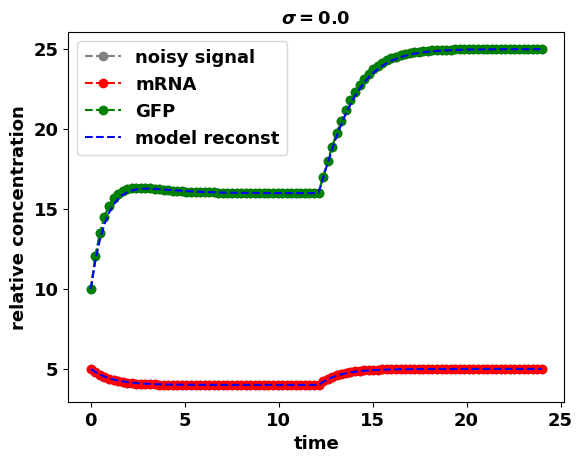

times_of_switches =  [12.12121212]
bounds= [(-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf)]
param_err =  0.9945998419101965
total_error =  0.04035705838132493
times_of_switches =  [12.12121212]
bounds= [(-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf)]
param_err =  1.6283444929397517
total_error =  0.07776697531392845
times_of_switches =  [12.12121212]
bounds= [(-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf)]
param_err =  1.8184072486294016
total_error =  0.10988359287875929
times_of_switches =  [12.12121212]
bounds= [(-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf)]
param_err =  1.893587522366612
total_error =  0.13890524365105222
times_of_switches =  [10.90909091]
bounds= [(-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf)]
param_err =  1.9033439343721164
total_error =  0.15757047885792969
times_of_switches =  [10.90909091]
bounds= [(-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf)]
param_err =  1.939203521164908
total_error =  0.1851603216423175
times_of_switches =  [8.4

In [6]:
## runs the algorithm to fit parameter estimates 

# Gets simulated data
num_time_grid_points = 100
data , t = sim_hybrid_promoter(num_time_grid_points)

m,n = np.shape(data)

# gets shape of data
num_time_pts , num_states = np.shape(data)

# switch detection parameters
switch_gap = num_time_pts//2
ls_model = "ar"

# noise_level*1.1 seems to work well for some noise levels
# sigma = noise_level*1.1

# number of switches
sigma='1'


# Sets initial parameter value guesses for first time domain 
#           [alpha, beta, bm,  bp]
params_init = [1.5, 1.5, 1.5, 1.5 ]

# set bounds for paramsin the form of : (lower, upper)
#         [alpha,    beta,     bm,     bp]
# bounds = [(0, 10), (0, 10), (1, 10), (1, 10)]
model_param_bounds = None

# amplifies signal
# noise_level = np.linspace(0,1,11)
noise_level = np.linspace(0,10, num_noise_levels)

# true params:
alpha = 4. 
beta = 4.
alpha2 = 5.
beta2 = 5.
bm = 1.
bp = 1.

param_true_arr = np.array([[alpha, alpha2], 
                          [beta, beta2], 
                          [bm, bm,], 
                          [bp, bp]])

num_static_params = 0

param_err_arr = np.zeros((len(noise_level),))

# noise to be added to data
np.random.seed(0)    # seed value for repeatable results
noise = np.random.randn(m,n)



reconstr_err = np.zeros((len(noise_level),))
haus_err = np.zeros((len(noise_level),))

for i in range(len(noise_level)):
    
    # adding noise to data
    noisy_data = data + noise_level[i] * noise

    result = cont_pw_tv_model_ID(noisy_data, t, switch_gap, 
                                 ls_model, 
                                 sigma, params_init,
                                 model_param_bounds,
                                 num_static_params)
    
    param_matrix = result['param_matrix']
    # print('total_error = ', result['total_err'])

    # param_err_arr[i] = LA.norm(np.abs(param_true_arr - param_matrix))
    param_err_arr[i] = LA.norm(param_true_arr - param_matrix, 2)/8
    print('param_err = ', param_err_arr[i])
    
    # results needed for plotting
    num_switches = result['num_switches']
    time_intervals_dict = result['time_intervals_dict']
    traj_dict = result['traj_dict']
    traj = result['traj']
    param_matrix = result['param_matrix']
    num_time_intervals = result['num_time_intervals']
    params_dict = result['params_dict']
    err_array = result['err_array']
    param_time = result['param_time']
    t_switch_index = result['t_switch_index']
    total_err = result['total_err']
    
    
    print('total_error = ', total_err)
    reconstr_err[i] = total_err
    
    haus_err[i] = hausdorff([num_time_pts//2, num_time_pts], [t_switch_index[0], num_time_pts])    

    num_model_params = np.shape(param_matrix)[0]

    # trajectory plot
    if i ==0:
        plt.figure(i)
        plt.plot(t, noisy_data[:, 0], '--o', color = 'gray', label='noisy signal')
        plt.plot(t, noisy_data[:, 1], '--o', color = 'gray')
        plt.plot(t, data[:, 0], 'r--o', label='mRNA')
        plt.plot(t, data[:, 1], 'g--o', label='GFP')
        plt.plot(t, traj[:, 0], '--', color='blue', label='model reconst')
        plt.plot(t, traj[:,1], '--', color='blue')
        plt.xlabel('time', fontsize=13, weight= 'bold')
        plt.ylabel('relative concentration', fontsize=13, weight= 'bold')
        plt.title(r'$\sigma =$' + str(noise_level[i]), fontsize=13, weight= 'bold')
        plt.legend(loc='best')
        plt.savefig(os.path.join(os.getcwd(), 'sigma' + str(noise_level[i]) + '.svg'), format='svg')

    plt.show()

param_err_all_runs[:,0] = param_err_arr
reconst_err_all_runs[:,0] = reconstr_err
hauss_err_all_runs[:,0] = haus_err


## algo run on advection diffusion sim data

In [7]:
## runs the algorithm to fit parameter estimates 

# need to change dynamics between runs of different systems
def pend(y, ti, a, d):
    
    n = len(y)
    
    # uniform grid spacing
    dx = 1 / n
    
    # boundary condition
    bc = np.zeros(len(y))

    # Initialize matrices
    row_xx = np.zeros(n)
    row_xx[0] = -2
    row_xx[1] = 1
    col_xx = row_xx

    row_x = np.zeros(n)
    row_x[0] = -1
    col_x = np.zeros(n)
    col_x[0] = -1
    col_x[1] = 1

    # Construct Toeplitz matrix
    T_x = toeplitz(col_x, row_x)
    T_xx = toeplitz(col_xx, row_xx)

    # Compute scaled matrices
    A_x = a * T_x / (dx)
    A_xx = d * T_xx / (dx**2)

    # Stack matrices
    A = A_x + A_xx
    # A = A_x

    dydt = A @ y + bc
    
    # Return the rates of change of the concentrations as a NumPy array
    return dydt

def obj_dynamics(y, ti, params):

    a, d = params
    
    n = len(y)
    
    # uniform grid spacing
    dx = 1 / n
    
    # boundary condition
    bc = np.zeros(len(y))

    # Initialize matrices
    row_xx = np.zeros(n)
    row_xx[0] = -2
    row_xx[1] = 1
    col_xx = row_xx

    row_x = np.zeros(n)
    row_x[0] = -1
    col_x = np.zeros(n)
    col_x[0] = -1
    col_x[1] = 1

    # Construct Toeplitz matrix
    T_x = toeplitz(col_x, row_x)
    T_xx = toeplitz(col_xx, row_xx)

    # Compute scaled matrices
    A_x = a * T_x / (dx)
    A_xx = d * T_xx / (dx**2)

    # Stack matrices
    A = A_x + A_xx
    # A = A_x

    dydt = A @ y + bc

    # Return the rates of change of the concentrations as a NumPy array
    return np.array([dydt])

In [8]:
def sim_advec_diff():
    
    ti = 0     # start time

    tf = 1    # end time



    n_t =  100   # number of time points
    n_x =  100    # number of space points

    t = np.linspace(ti, tf, n_t)

    dt = t[1] - t[0]

    # space step size
    dx =  np.pi / n_x 

    # x grid
    x = np.linspace(-np.pi/4, np.pi + np.pi/4, n_x)

    T, X = np.meshgrid(t, x)

    ## create initial condition 
    ## u(x) = x      if x <= pi/2
    ##      = pi - x if x >= pi/2
    # u0 = np.zeros((n,))
    # for i in range(n):
    #     if x[i] <= np.pi / 2:
    #         u0[i] = x[i]
    #     else:
    #         u0[i] = np.pi - x[i]

    # u0 = np.ones((n_x,))

    # create initial condition 
    u0 = np.zeros((n_x,))
    for i in range(n_x):
        if x[i] >0 and x[i] < np.pi :
            u0[i] = np.sin(3*x[i])
    

    ########################################################  
    ## parameters
    a = .01 
    d = .01

    ######################################################## 
    ## Simulate trajectories

    num_time_ints = 2

    break_len = len(t)//num_time_ints


    # used to iterate through every time point
    temp_index = 0  

    # true solution over first time interval
    u_true = odeint(pend, u0, t[temp_index : temp_index + break_len], args = (a, d))


    for i in range(num_time_ints):

        # update params
        a = a + 1.
        d = d + 1.

        u0 = u_true[-1,:]

        # updtate the index of the current time point
        temp_index = temp_index + break_len

        # true solution over next time interval
        u_new = odeint(pend, u0, t[temp_index : temp_index + break_len ], args = (a, d))
        u_true = np.append(u_true, u_new, axis=0)

    # true solution over last time interval
    u0 = u_true[-1,:]
    u_new = odeint(pend, u0, t[temp_index:], args = (a, d))
    u_true = np.append(u_true, u_new, axis=0)
    
    data = u_true
    
    return data , t

times_of_switches =  [0.50505051]
bounds= [(-inf, inf), (-inf, inf)]
param_err =  0.23442831517585302
total_error =  0.015343766998040624


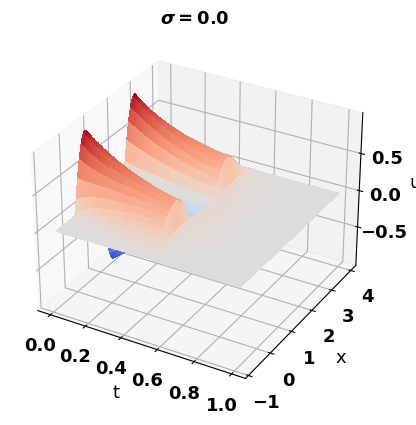

times_of_switches =  [0.15151515]
bounds= [(-inf, inf), (-inf, inf)]
param_err =  0.3541693396940382
total_error =  0.2228514181771396
times_of_switches =  [0.15151515]
bounds= [(-inf, inf), (-inf, inf)]
param_err =  0.3545805508150505
total_error =  0.227019624414637
times_of_switches =  [0.15151515]
bounds= [(-inf, inf), (-inf, inf)]
param_err =  0.35511926409575106
total_error =  0.22799460846683847
times_of_switches =  [0.1010101]
bounds= [(-inf, inf), (-inf, inf)]
param_err =  0.3560068139769128
total_error =  0.2375972561827006
times_of_switches =  [0.05050505]
bounds= [(-inf, inf), (-inf, inf)]
param_err =  0.3555408318676525
total_error =  0.2525077670343212
times_of_switches =  [0.05050505]
bounds= [(-inf, inf), (-inf, inf)]
param_err =  0.35592422477175134
total_error =  0.25227647313390766
times_of_switches =  [0.05050505]
bounds= [(-inf, inf), (-inf, inf)]
param_err =  0.3563237784613286
total_error =  0.25244469870261976
times_of_switches =  [0.05050505]
bounds= [(-inf, in

In [9]:
ti = 0     # start time

tf = 1    # end time

n_t =  100   # number of time points
n_x =  100    # number of space points

t = np.linspace(ti, tf, n_t)

dt = t[1] - t[0]

# space step size
dx =  np.pi / n_x 

# x grid
x = np.linspace(-np.pi/4, np.pi + np.pi/4, n_x)

T, X = np.meshgrid(t, x)

# Gets simulated data
data , t = sim_advec_diff()

m,n = np.shape(data)

# gets shape of data
num_time_pts , num_states = np.shape(data)

# switch detection parameters
switch_gap = num_time_pts//4
ls_model = "ar"

# noise_level*1.1 seems to work well for some noise levels
# sigma = noise_level*1.1

# number of switches
sigma='1'


# Sets initial parameter value guesses for first time domain 
params_init = [1.5, 1.5]

# set bounds for paramsin the form of : (lower, upper)
# bounds = [(0, 10), (0, 10), (1, 10), (1, 10)]
model_param_bounds = None

# amplifies signal
# noise_level = np.linspace(0,1,11)
noise_level = np.linspace(0,10,41)

# true params:
alpha = .01
beta = .01
alpha2 = 1.01
beta2 = 1.01

param_true_arr = np.array([[alpha, alpha2], 
                          [beta, beta2]]) 
                   

num_static_params = 0

param_err_arr = np.zeros((len(noise_level),))

# noise to be added to data
np.random.seed(0)    # seed value for repeatable results

# We divide by 25 here because 25 is the max of the first hybrid promoter data.
# We do this to keep the noise consistent across systems, since the max of the 
# advec diff system is 1.
noise = (1/25)*np.random.randn(m,n)



reconstr_err = np.zeros((len(noise_level),))
haus_err = np.zeros((len(noise_level),))

for i in range(len(noise_level)):
    
    # adding noise to data
    noisy_data = data + noise_level[i] * noise

    result = cont_pw_tv_model_ID(noisy_data, t, switch_gap, 
                                 ls_model, 
                                 sigma, params_init,
                                 model_param_bounds,
                                 num_static_params)
    
    param_matrix = result['param_matrix']
    # print('total_error = ', result['total_err'])

    # param_err_arr[i] = LA.norm(np.abs(param_true_arr - param_matrix))
    param_err_arr[i] = LA.norm(param_true_arr - param_matrix, 2)/4
    print('param_err = ', param_err_arr[i])
    
    # results needed for plotting
    num_switches = result['num_switches']
    time_intervals_dict = result['time_intervals_dict']
    traj_dict = result['traj_dict']
    traj = result['traj']
    param_matrix = result['param_matrix']
    num_time_intervals = result['num_time_intervals']
    params_dict = result['params_dict']
    err_array = result['err_array']
    param_time = result['param_time']
    t_switch_index = result['t_switch_index']
    total_err = result['total_err']
    
    
    print('total_error = ', total_err)
    reconstr_err[i] = total_err
    
    haus_err[i] = hausdorff([num_time_pts//2, num_time_pts], [t_switch_index[0], num_time_pts])    

    num_model_params = np.shape(param_matrix)[0]

    # trajectory plot
    if i ==0:
        fig = plt.figure()
        ax = fig.add_subplot( projection='3d')
        surf = ax.plot_surface(T, X, noisy_data.T, cmap = 'coolwarm',
                        linewidth=0, antialiased=False)
        # fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_xlabel('t')
        ax.set_ylabel('x')
        ax.set_zlabel('u');
        plt.title(r'$\sigma =$' + str(noise_level[i]), fontsize=13, weight= 'bold')
        # plt.savefig(os.path.join(os.getcwd(), 'sigma' + str(noise_level[i]) + '.svg'), format='svg')

    plt.show()

param_err_all_runs[:,1] = param_err_arr
reconst_err_all_runs[:,1] = reconstr_err
hauss_err_all_runs[:,1] = haus_err
    

## algo run on 3-state oscillatory system sim data

In [10]:
# dynamics for simulation
def pend(y, ti, p):
    
    # 2 state system 
    x, y, z = y
    
    dydt = [ y + z , 
            p, 
            -x*y]
    
    # Return the rates of change of the concentrations as a NumPy array
    return dydt

def obj_dynamics(y, ti, params):

    p = params
    
    # 2 state system 
    x1 = y[0]
    x2 = y[1]
    x3 = y[2]
    
    dydt = [ x2+x3 , 
            p[0], 
            -x1*x2]

    # Return the rates of change of the concentrations as a NumPy array
    return np.array([dydt])

In [11]:
def sim_3state():

    # initial condition for simulation
    y0 = [1., 2., 3.]

    ti = 0      # start time

    tf = 24     # end time
    
    # define time vector
    num_time_grid_points = 100
    t = np.linspace(ti, tf, num_time_grid_points)
    print(len(t))
    
    dt = t[1] - t[0]

    ########################################################  
    ## parameters
    p = 1.

    ######################################################## 
    ## Simulate trajectories

    num_time_ints = 2

    break_len = len(t)//num_time_ints


    # used to iterate through every time point
    temp_index = 0  

    # true solution over first time interval
    u_true = odeint(pend, y0, t[temp_index : temp_index + break_len], args = (p,))


    for i in range(num_time_ints):

        # update params
        p = p + 1.

        u0 = u_true[-1,:]

        # updtate the index of the current time point
        temp_index = temp_index + break_len

        # true solution over next time interval
        u_new = odeint(pend, u0, t[temp_index : temp_index + break_len ], args = (p,))
        u_true = np.append(u_true, u_new, axis=0)

    # true solution over last time interval
    u0 = u_true[-1,:]
    u_new = odeint(pend, u0, t[temp_index:], args = (p,))
    u_true = np.append(u_true, u_new, axis=0)
    
    data = u_true
    
    return data , t

100
times_of_switches =  [12.12121212]
bounds= [(-inf, inf)]
param_err =  2.121311712886047
total_error =  0.00010152188421114546


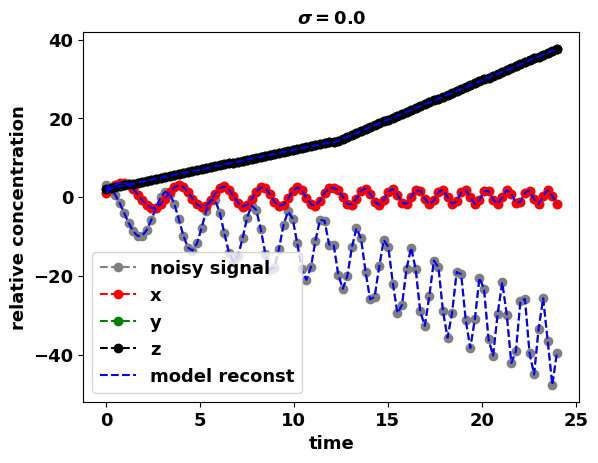

times_of_switches =  [13.33333333]
bounds= [(-inf, inf)]
param_err =  2.0988501943725164
total_error =  0.31207804191961264
times_of_switches =  [13.33333333]
bounds= [(-inf, inf)]
param_err =  2.0959522407881823
total_error =  0.3997675086840305
times_of_switches =  [13.33333333]
bounds= [(-inf, inf)]
param_err =  2.093078008308746
total_error =  0.49063162798839177
times_of_switches =  [2.42424242]
bounds= [(-inf, inf)]
param_err =  2.1436871106508164
total_error =  0.8278565734726934
times_of_switches =  [2.42424242]
bounds= [(-inf, inf)]
param_err =  2.1105712225662088
total_error =  0.8367234394912798
times_of_switches =  [2.42424242]
bounds= [(-inf, inf)]
param_err =  2.0788997788973638
total_error =  0.8480015356221289
times_of_switches =  [2.42424242]
bounds= [(-inf, inf)]
param_err =  2.0488511572248527
total_error =  0.8607868061454867
times_of_switches =  [2.42424242]
bounds= [(-inf, inf)]
param_err =  2.02042714082636
total_error =  0.8757044469770715
times_of_switches =  [

In [12]:
## runs the algorithm to fit parameter estimates 

# Gets simulated data
data , t = sim_3state()

m,n = np.shape(data)

# gets shape of data
num_time_pts , num_states = np.shape(data)

# switch detection parameters
switch_gap = num_time_pts//2
ls_model = "ar"

# noise_level*1.1 seems to work well for some noise levels
# sigma = noise_level*1.1

# number of switches
sigma='1'


# Sets initial parameter value guesses for first time domain 
params_init = [1.5]

# set bounds for paramsin the form of : (lower, upper)
# bounds = [(0, 10), (0, 10), (1, 10), (1, 10)]
model_param_bounds = None

# amplifies signal
# noise_level = np.linspace(0,1,11)
noise_level = np.linspace(0,10,num_noise_levels)

# true params:
alpha = 4. 

alpha2 = 5.


param_true_arr = np.array([[alpha, alpha2]]) 
                   

num_static_params = 0

param_err_arr = np.zeros((len(noise_level),))

# noise to be added to data
np.random.seed(0)    # seed value for repeatable results
noise = np.random.randn(m,n)



reconstr_err = np.zeros((len(noise_level),))
haus_err = np.zeros((len(noise_level),))

for i in range(len(noise_level)):
    
    # adding noise to data
    noisy_data = data + noise_level[i] * noise

    result = cont_pw_tv_model_ID(noisy_data, t, switch_gap, 
                                 ls_model, 
                                 sigma, params_init,
                                 model_param_bounds,
                                 num_static_params)
    
    param_matrix = result['param_matrix']
    # print('total_error = ', result['total_err'])

    # param_err_arr[i] = LA.norm(np.abs(param_true_arr - param_matrix))
    param_err_arr[i] = LA.norm(param_true_arr - param_matrix, 2)/2
    print('param_err = ', param_err_arr[i])    
    
    # results needed for plotting
    num_switches = result['num_switches']
    time_intervals_dict = result['time_intervals_dict']
    traj_dict = result['traj_dict']
    traj = result['traj']
    param_matrix = result['param_matrix']
    num_time_intervals = result['num_time_intervals']
    params_dict = result['params_dict']
    err_array = result['err_array']
    param_time = result['param_time']
    t_switch_index = result['t_switch_index']
    total_err = result['total_err']
    
    
    print('total_error = ', total_err)
    reconstr_err[i] = total_err
    
    haus_err[i] = hausdorff([num_time_pts//2, num_time_pts], [t_switch_index[0], num_time_pts])    

    num_model_params = np.shape(param_matrix)[0]

    # trajectory plot
    if i ==0:
        plt.figure(i)
        plt.plot(t, noisy_data[:, 0], '--o', color = 'gray', label='noisy signal')
        plt.plot(t, noisy_data[:, 1], '--o', color = 'gray')
        plt.plot(t, noisy_data[:, 2], '--o', color = 'gray')
        plt.plot(t, data[:, 0], 'r--o', label='x')
        plt.plot(t, data[:, 1], 'g--o', label='y')
        plt.plot(t, data[:, 1], 'k--o', label='z')
        plt.plot(t, traj[:, 0], '--', color='blue', label='model reconst')
        plt.plot(t, traj[:,1], '--', color='blue')
        plt.plot(t, traj[:,2], '--', color='blue')
        plt.xlabel('time', fontsize=13, weight= 'bold')
        plt.ylabel('relative concentration', fontsize=13, weight= 'bold')
        plt.title(r'$\sigma =$' + str(noise_level[i]), fontsize=13, weight= 'bold')
        plt.legend(loc='best')
        plt.savefig(os.path.join(os.getcwd(), 'sigma' + str(noise_level[i]) + '.svg'), format='svg')

    plt.show()
    
param_err_all_runs[:,2] = param_err_arr
reconst_err_all_runs[:,2] = reconstr_err
hauss_err_all_runs[:,2] = haus_err

    

## Plot statistical error over all runs

In [13]:
print(reconst_err_all_runs)

reconst_mean_vector, reconst_std_vector, reconst_sem_vector, = get_stats(reconst_err_all_runs)
param_mean_vector, param_std_vector, param_sem_vector = get_stats(param_err_all_runs)
hauss_mean_vector, hauss_std_vector, hauss_sem_vector = get_stats(hauss_err_all_runs)

reconst_min_err, reconst_max_err = variability_min_max(reconst_err_all_runs)
param_min_err, param_max_err = variability_min_max(param_err_all_runs)
hauss_min_err, hauss_max_err = variability_min_max(hauss_err_all_runs)

[[1.36095193e-02 1.53437670e-02 1.01521884e-04]
 [4.03570584e-02 2.22851418e-01 3.12078042e-01]
 [7.77669753e-02 2.27019624e-01 3.99767509e-01]
 [1.09883593e-01 2.27994608e-01 4.90631628e-01]
 [1.38905244e-01 2.37597256e-01 8.27856573e-01]
 [1.57570479e-01 2.52507767e-01 8.36723439e-01]
 [1.85160322e-01 2.52276473e-01 8.48001536e-01]
 [2.63833931e-01 2.52444699e-01 8.60786806e-01]
 [2.93908526e-01 2.51956195e-01 8.75704447e-01]
 [3.28578482e-01 2.52150634e-01 8.92341855e-01]
 [3.67239917e-01 2.51922906e-01 9.10933048e-01]
 [4.09247459e-01 2.51746110e-01 9.31466454e-01]
 [4.53948552e-01 2.51628709e-01 9.53546160e-01]
 [5.00772333e-01 2.51534467e-01 9.77373983e-01]
 [5.49188780e-01 2.51444624e-01 1.00249240e+00]
 [5.98754328e-01 2.51373634e-01 1.02899054e+00]
 [6.49061762e-01 2.51320327e-01 1.05645754e+00]
 [6.99783827e-01 2.51273715e-01 1.08510145e+00]
 [7.50649191e-01 2.51256671e-01 1.16918667e+00]
 [8.01413275e-01 2.51252803e-01 1.12099178e+00]
 [8.51899915e-01 2.51794389e-01 1.105246

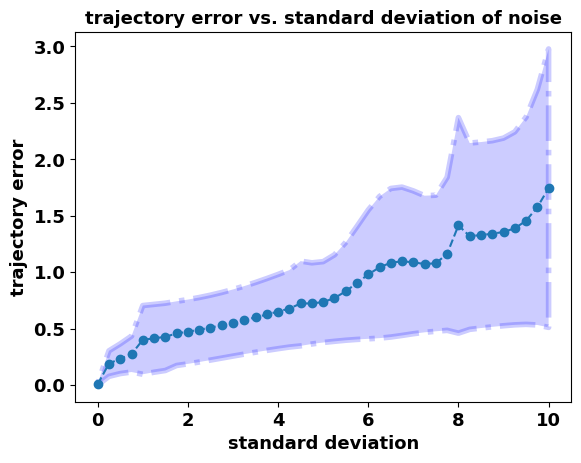

In [14]:
plt.plot(noise_level, reconst_mean_vector, 'o--')  

# plt.fill_between(noise_level, reconst_min_err, reconst_max_err,
#                         alpha=0.2, edgecolor='g', facecolor='g',
#                         linewidth=4, linestyle='dashdot', 
#                         label = 'min , max', antialiased=True)
        
plt.fill_between(noise_level, 
                 np.add(reconst_mean_vector, -reconst_std_vector), 
                 np.add(reconst_mean_vector, reconst_std_vector),
                 alpha=0.2, edgecolor='b', facecolor='b',
                 linewidth=4, linestyle='dashdot', label = 'stdev error', antialiased=True)

# plt.fill_between(noise_level, 
#                  np.add(reconst_mean_vector, -reconst_sem_vector), 
#                  np.add(reconst_mean_vector, reconst_sem_vector),
#                  alpha=0.2, edgecolor='r', facecolor='r',
#                  linewidth=4, linestyle='dashdot', label = 'standard error', antialiased=True)

plt.xlabel('standard deviation', fontsize=13, weight= 'bold')
plt.ylabel('trajectory error', fontsize=13, weight= 'bold')
plt.title('trajectory error vs. standard deviation of noise', fontsize=13, weight= 'bold')
plt.savefig(os.path.join(os.getcwd(), 'traj_error.svg'), format='svg')

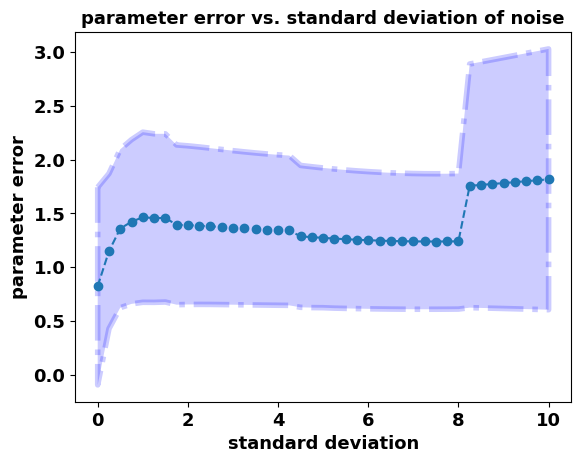

In [15]:
plt.plot(noise_level,param_mean_vector, 'o--')  

# plt.fill_between(noise_level, param_min_err, param_max_err,
#                         alpha=0.2, edgecolor='g', facecolor='g',
#                         linewidth=4, linestyle='dashdot', 
#                         label = 'min , max', antialiased=True)
        
plt.fill_between(noise_level, 
                 np.add(param_mean_vector, -param_std_vector), 
                 np.add(param_mean_vector, param_std_vector),
                 alpha=0.2, edgecolor='b', facecolor='b',
                 linewidth=4, linestyle='dashdot', label = 'stdev error', antialiased=True)

# plt.fill_between(noise_level, 
#                  np.add(param_mean_vector, -param_sem_vector), 
#                  np.add(param_mean_vector, param_sem_vector),
#                  alpha=0.2, edgecolor='r', facecolor='r',
#                  linewidth=4, linestyle='dashdot', label = 'standard error', antialiased=True)

plt.xlabel('standard deviation', fontsize=13, weight= 'bold')
plt.ylabel('parameter error', fontsize=13, weight= 'bold')
plt.title('parameter error vs. standard deviation of noise', fontsize=13, weight= 'bold')
plt.savefig(os.path.join(os.getcwd(), 'param_error.svg'), format='svg')

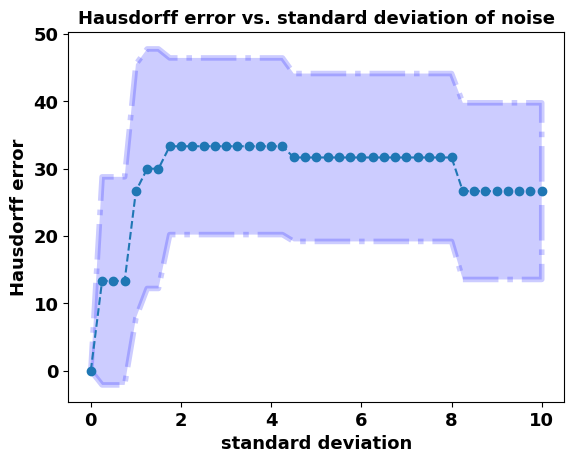

In [16]:
plt.plot(noise_level, hauss_mean_vector, 'o--')  

# plt.fill_between(noise_level, hauss_min_err, hauss_max_err,
#                         alpha=0.2, edgecolor='g', facecolor='g',
#                         linewidth=4, linestyle='dashdot', 
#                         label = 'min , max', antialiased=True)
        
plt.fill_between(noise_level, 
                 np.add(hauss_mean_vector, -hauss_std_vector), 
                 np.add(hauss_mean_vector, hauss_std_vector),
                 alpha=0.2, edgecolor='b', facecolor='b',
                 linewidth=4, linestyle='dashdot', label = 'stdev error', antialiased=True)

# plt.fill_between(noise_level, 
#                  np.add(hauss_mean_vector, -hauss_sem_vector), 
#                  np.add(hauss_mean_vector, hauss_sem_vector),
#                  alpha=0.2, edgecolor='r', facecolor='r',
#                  linewidth=4, linestyle='dashdot', label = 'standard error', antialiased=True)

plt.xlabel('standard deviation', fontsize=13, weight= 'bold')
plt.ylabel('Hausdorff error', fontsize=13, weight= 'bold')
plt.title('Hausdorff error vs. standard deviation of noise', fontsize=13, weight= 'bold')
plt.savefig(os.path.join(os.getcwd(), 'hauss_error.svg'), format='svg')